# Fitting Notebook
Here we fit the phi-distributions from the analysis notebook.
- Model selection - Cross validation score is used to demonstrate that fitting with the simple model is probably best.
- Fits of $\phi$ - Two methods of fitting the phi distributions are used, one single fit, and the bootstrap replica technique.
- MC study of fitting procedure - This has to wait, but I am going to use MC to throw a distribution in phi that follows the error bars of our measurement.
- Visualization
    - fit phi distributions 
    - bootstrap histograms
    - bootstrap score histograms
    - integrated fit results with errors

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('font', size=18)

### Load Data
Here the data is loaded from the previous notebook called `analysis.ipynb`.  

In [2]:
data = pd.read_csv('results/phi-dist.csv')

In [3]:
data.columns

Index([u'axis', u'axis_bin', u'axis_max', u'axis_min', u'counts_neg',
       u'counts_pos', u'phi', u'phi_bin', u'stat', u'sys_0', u'value',
       u'global_index', u'sys_1', u'sys_10', u'sys_11', u'sys_2', u'sys_3',
       u'sys_4', u'sys_5', u'sys_6', u'sys_7', u'sys_8', u'sys_9',
       u'sys_total'],
      dtype='object')

### Setup Fitting 
Our model is defined below, it can be one of several different functions.  Fitting is done by minimizing the $\chi^2$.  Errors are estimated with the covariance matrix, or the bootstrap replica method.  Cross validation is defined, and the different models are evaluated.  

In [4]:
def chi2(y_true, y_pred, y_err):
    return np.sum((y_true-y_pred)**2/y_err**2)

In [5]:
class Model(object):

    def __init__(self):
        self.n_pars = 1
        self.pars   = np.zeros(shape=(self.n_pars, 1))
        self.bounds = np.array([[-1, 1],], dtype=np.float32)
        
    def get_initial_parameters(self):
        self.pars = np.random.uniform(-1.0, 1.0, size=(self.n_pars, 1))

    def evaluate(self, x):
        return 1.0

class SineModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 1
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 )

class FullModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 3
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        self.bounds = np.array([[-1,1],
                                [-1,1],
                                [-1,1]],dtype=np.float32)
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 ) / (1 + self.pars[1]*np.cos(x*np.pi/180.0) + self.pars[2]*np.cos(2*x*np.pi/180.0))

def update_model(model, pars, x):
    model.pars = pars
    return model.evaluate(x)

In [6]:
from scipy.optimize import minimize

In [7]:
model = FullModel()
model.get_initial_parameters()

In [8]:
test_data = data.query('axis == "z" and axis_bin == 2')

In [9]:
from sklearn.utils import shuffle

def setup_dataframe(n_folds, x, y, y_err, shuf=False):
    
    if len(y) % n_folds != 0:
        print('Data (%d) is not divisible into %d folds.' % (len(y), n_folds))
        return 
    
    x = x.transpose()
    y = y.transpose()
    y_err = y_err.transpose()
    
    d  = {'x':x, 'y':y, 'y_err':y_err}
    df = pd.DataFrame(data=d)
    
    if shuf is True:
        df = shuffle(df)

    chunk_size = int(len(y)/n_folds) 
    
    a = np.arange(0,n_folds)
    df['chunk'] = np.repeat(a,chunk_size)
    return df

def cross_validate(n_folds, model, df):

    validation_scores = []
    parameters = []
    for i in range(n_folds):
        res = minimize(fun=lambda p: np.average((df.query('chunk != %d' % i).y - update_model(model, p, df.query('chunk != %d' % i).x))**2/df.query('chunk != %d' % i).y_err**2), 
                    x0=model.pars, bounds=model.bounds)
                                
        y_pred = update_model(model, res.x, df.query('chunk == %d' % i).x)
        validation_scores.append(np.average((df.query('chunk == %d' % i).y-y_pred)**2/df.query('chunk == %d' % i).y_err**2))
        parameters.append(res.x)
        
    return np.array(validation_scores), parameters

In [10]:
models = {}

models['basic'] = SineModel()
models['full'] = FullModel()
models['half'] = FullModel()
models['half'].bounds = np.array([[-1,1],[-1,1],[-0.0001,0.0001]], dtype=np.float32)

models['full_bounded'] = FullModel()
models['full_bounded'].bounds = np.array([[-1,1],[-0.1,0.1],[-0.1,0.1]], dtype=np.float32)
                                          
for m in models.values():
    m.get_initial_parameters()

### Cross Validation
Compare different models.

In [11]:
CHUNKS = 12
df_chunked = setup_dataframe(CHUNKS, test_data.phi, test_data.value, np.sqrt(test_data.sys_total**2 + test_data.stat**2), shuf=False)

In [12]:
cv_scores = {}
cv_pars = {}

for name, m in models.iteritems():
    print('Fitting %s' % name)
    cv_scores[name], cv_pars[name] = cross_validate(CHUNKS, m, df_chunked)

Fitting full_bounded
Fitting half
Fitting full
Fitting basic


In [13]:
for k,v in cv_scores.iteritems():
    print('Model %s, Score %.2f' % (k, np.average(v)))

Model basic, Score 1.31
Model full_bounded, Score 1.57
Model full, Score 3.95
Model half, Score 1.55


In [14]:
!mkdir image/

mkdir: image/: File exists


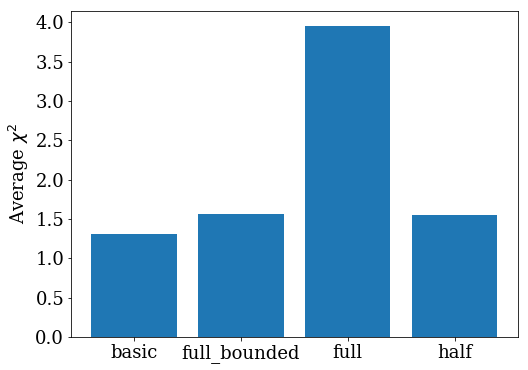

In [15]:
h = [np.average(xx) for xx in cv_scores.values()]
e = [np.std(xx) for xx in cv_scores.values()]
plt.figure(figsize=(8,6))
plt.bar(np.arange(len(cv_scores.keys())), height=h)
plt.xticks(np.arange(len(cv_scores.keys())), cv_scores.keys())
plt.ylabel('Average $\chi^2$')
plt.savefig('image/cv-score-models.pdf', bbox_inches='tight')

In [16]:
#plt.figure(figsize=(8,6))
#plt.errorbar(x=np.arange(len(cv_scores.keys())), y=h, yerr=e,
#            linestyle='', marker='o')
#plt.xticks(np.arange(len(cv_scores.keys())), cv_scores.keys())

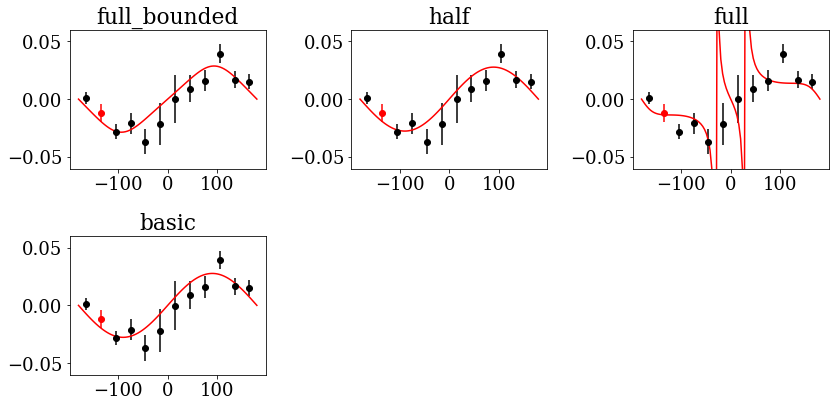

In [17]:
n_col = 3
n_row = np.ceil((len(cv_pars.keys())-1)/n_col)+1
plt.figure(figsize=(n_col*4, n_row*3))

train = df_chunked.query('chunk != 1')
test  = df_chunked.query('chunk == 1')

index = 1
x = np.linspace(-180,180,100)
for name, model in models.iteritems():
    plt.subplot(n_row, n_col, index)
    plt.errorbar(train.x, train.y, train.y_err, linestyle='', marker='o', color='black')
    plt.errorbar(test.x, test.y, test.y_err, linestyle='', marker='o', color='red')
    plt.ylim([-0.06, 0.06])
    
    y = [update_model(model, cv_pars[name][1], xi) for xi in x]
    plt.plot(x, y, color='red')
    index += 1
    
    plt.title(name)
    
plt.tight_layout()
plt.savefig('image/cv-demo-models.pdf', bbox_inches='tight')

### Toy Dataset Testing 
This toy dataset is used to study what we can actually extract.  The section should be moved to another part of the notebook.

In [18]:
def generate_toy_data(df, model):
    d = df.copy(deep=True)
    d.value = model.evaluate(d.phi) + np.random.normal(loc=0.0, scale=np.sqrt(d.stat**2 + d.sys_total**2))
    return d

In [19]:
#models['full'].pars = [0.05, 0.02, -0.02]
models['basic'].pars = [0.05]
mc = generate_toy_data(test_data, models['basic'])

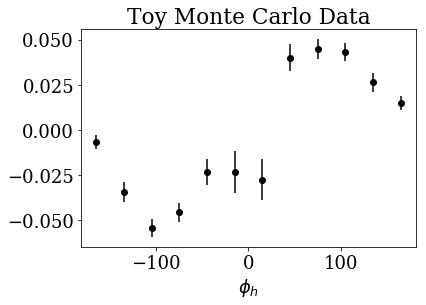

In [20]:
plt.errorbar(x=mc.phi, y=mc.value, yerr=mc.stat, color='black', 
            linestyle='', marker='o')
plt.xlabel('$\phi_h$')
plt.title('Toy Monte Carlo Data')

In [21]:
rmc = minimize(fun=lambda x: chi2(mc.value, update_model(models['full'], x, mc.phi), np.sqrt(mc.stat**2 + mc.sys_total**2)), 
             x0=models['full'].pars,
            bounds=models['full'].bounds)

In [22]:
rmc

      fun: 62.615509696846225
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.12638804e-05,   4.26325641e-06,   4.97379915e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 80
      nit: 15
   status: 0
  success: True
        x: array([ 0.04956453, -0.58258196, -0.87294052])

In [23]:
def single_fit(model, data):
    model.get_initial_parameters()
    res = minimize(fun=lambda x: chi2(data.value, update_model(model, x, data.phi), np.sqrt(data.stat**2 + data.sys_total**2)), 
             x0=model.pars, bounds=model.bounds)

    identity = np.identity(len(model.pars))
    err = np.sqrt(np.array(np.matrix(res.hess_inv * identity).diagonal()))
    #err.reshape(model.n_pars,1)
    
    return res.x, err

In [24]:
def create_replica(y, y_err):
    y_rep = [np.random.normal(yp,np.fabs(yp_err)) for yp,yp_err in zip(y,y_err)]
    return np.array(y_rep)

In [ ]:
import sys

def bootstrap_fit(model, data, n_replicas=100):

    results = []
    scores = []
    
    for irep in range(n_replicas):
        d = data.copy(deep=True)
        rep = create_replica(d.value, np.sqrt(d.stat**2 + d.sys_total**2)) 
        d['value'] = rep   
        pars,errs = single_fit(model, d)
        results.append(pars)
        scores.append(chi2(d.value, update_model(model, pars, d.phi), np.sqrt(d.stat**2 + d.sys_total**2)))
        
        if irep%10 is 0:
            sys.stdout.write('\rProcessing replica (%d/%d)' % (irep, n_replicas))
            sys.stdout.flush()
            
    return np.array(results), np.array(scores)

In [ ]:
boot,boot_score = bootstrap_fit(models['half'], test_data, 400)

Processing replica (360/400)

In [ ]:
hb = np.linspace(-0.3, 0.3, 80)
plt.hist(boot[:,0], bins=hb, normed=True, histtype='stepfilled',
        color='red', edgecolor='black', alpha=0.7, hatch='///');
plt.hist(boot[:,1], bins=hb, normed=True, histtype='stepfilled',
        color='blue', edgecolor='black', alpha=0.7, hatch='///');
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.savefig('image/bootstrap-demo-pdf.pdf', bbox_inches='tight')

In [ ]:
np.average(boot[:,0]), np.std(boot[:,0])

In [ ]:
np.average(boot[:,1]), np.std(boot[:,1])

In [ ]:
def fit_dataset(data, model, fit_type='single'):
    '''
    inputs
    ------
    
    data: a dataframe which contains the output of the analysis notebook, phi-distributions 
    
    model: a model object
    
    '''
    
    result = {}
    result['axis'] = []
    result['axis_bin'] = []
    
    for p in range(model.n_pars):
        result['par_%d' % p] = []
        result['err_%d' % p] = []
        
    for axis in np.unique(data.axis):
        dsub = data.query('axis == "%s"' % axis)
        
        for bin in np.unique(dsub.axis_bin):
            d = dsub.query('axis_bin == %d' % bin)
            
            print(' Fitting %s,%d' % (axis, bin))
            
            # get fit to data
            #pars,errs = single_fit(model, dsub)
            boot, boots = bootstrap_fit(model, d, n_replicas=80)
            
            pars = []
            errs = []
            for ipar in range(model.n_pars):
                pars.append(np.average(boot[:,ipar]))
                errs.append(np.std(boot[:,ipar]))
            
            result['axis'].append(axis)
            result['axis_bin'].append(bin)
            
            for p in range(model.n_pars):
                result['par_%d' % p].append(pars[p])
                result['err_%d' % p].append(errs[p])
            
    return pd.DataFrame(result)

In [ ]:
fitres = fit_dataset(data, models['basic'])

In [ ]:
plt.errorbar(x=fitres.query('axis == "q2"').axis_bin, 
             y=fitres.query('axis == "q2"').par_0, 
             yerr=fitres.query('axis == "q2"').err_0,
            linestyle='', marker='o', color='black')

plt.ylim([-0.02, 0.1])
plt.axhline(0.0, linestyle='--', color='black', alpha=0.8, linewidth=1)
#plt.grid(color='black', alpha=0.2)

In [ ]:
import scipy.stats as stats

In [ ]:
plt.hist(boot_score, bins=50, normed=True, histtype='stepfilled',
        color='red', edgecolor='black', hatch='//', alpha=0.7);

x = np.linspace(0, 60, 100)
plt.plot(x, stats.chi2.pdf(x,24), linestyle='-.', color='black', linewidth=2.0)

plt.xlabel('$\chi^2$')
plt.title('Scores from Bootstraps')

In [ ]:
def plot_results(results, axis):
    
    d      = results.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
    phi_width = np.repeat(float(360.0/len(np.unique(d.phi_bin))), len(np.unique(d.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(d.phi_bin)))
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(x=dsub.phi, y=dsub.value, yerr=dsub.stat, 
                    linestyle='', marker='o', color='black')
        
        if 'sys_total' in dsub.columns:
            plt.bar(phi_edges, height=dsub.sys_total, width=phi_width, bottom=0.0, 
                    edgecolor='red', color='yellow', alpha=0.65, hatch='///', 
                    label='systematic error', align='edge')
            
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.7)
        
        plt.xlim([-180,180])
        plt.ylim([-0.15, 0.15])
        
    plt.tight_layout()

In [ ]:
plot_results(data, axis='pt')

In [ ]:
fitres

In [ ]:
results = pd.merge(data, fitres, on=['axis', 'axis_bin'])

In [ ]:
results.to_csv('results/phi-dist-fit.csv', index=False)

### Comparing Statistics of Replicas
There is some discussion that the chi-2 distribution should peak at $2 \nu$

In [ ]:
replicas = []

for i in range(1000):
    replicas.append(create_replica(y=test_data.value, y_err=test_data.stat))

In [ ]:
replicas = np.array(replicas)

In [ ]:
for i in range(12):
    print(i, np.average(replicas[:,i]), test_data.value.values[i], 
         np.std(replicas[:,i]), test_data.stat.values[i])

In [ ]:
n_col = 3
n_row = 4
plt.figure(figsize=(12, 5))

for i in range(12):
    plt.subplot(n_row, n_col, i+1)
    plt.hist(replicas[:,i], bins=50, normed=True, histtype='stepfilled',
        color='red', edgecolor='black', hatch='//', alpha=0.7);
    plt.axvspan(test_data.value.values[i]-test_data.stat.values[i], 
           test_data.value.values[i]+test_data.stat.values[i],
           alpha=0.2, color='black')
    plt.axvline(np.average(replicas[:,i])-np.std(replicas[:,i]), color='black', linestyle='-.')
    plt.axvline(np.average(replicas[:,i])+np.std(replicas[:,i]), color='black', linestyle='-.')

plt.tight_layout()

The statistics look exactly the same to me.  I actually derived it on paper as well.

### Plot for Bootstraps Demo

In [ ]:
phi = np.linspace(-180,180,100)
for pars in boot:
    plt.plot(phi, update_model(models['full'], pars, phi), color='red', alpha=0.02)

plt.errorbar(test_data.phi, test_data.value, np.sqrt(test_data.sys_total**2 + test_data.stat**2),
        linestyle='', marker='o', color='black')
plt.ylabel('BSA')
plt.xlabel('$\phi_h$')
plt.axhline(0.0, color='black', linestyle='--', alpha=0.7, linewidth=1)
plt.savefig('image/bootstrap-demo.pdf', bbox_inches='tight')

In [ ]:
def plot_summary(results):

    latex = {}
    latex['x'] = '$x$'
    latex['z'] = '$z$'
    latex['pt'] = '$P_T$'
    latex['q2'] = '$Q^2$'
    
    axes = np.unique(results.axis)
    
    n_col = 2
    n_row = 1 + np.ceil(len(axes)/n_col)
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    for index, axis in enumerate(axes):
        plt.subplot(n_row, n_col, index+1)
        d = results.query('axis == "%s"' % axis)
        
        plt.errorbar(d.axis_min + 0.5*(d.axis_max-d.axis_min), d.par_0, d.err_0,
                    linestyle='', marker='o', color='black')
        plt.xlabel(latex[axis])
        plt.ylabel('$A_{LU}^{\sin\phi}$')
        plt.ylim([-0.02, 0.08])
        plt.axhline(0.0, color='black', alpha=0.7, linestyle='--', linewidth=1)
        
    plt.tight_layout()

In [ ]:
plot_summary(results)
plt.savefig('image/summary.pdf', bbox_inches='tight')

In [ ]:
def plot_axis(result, model, axis):
        
    d      = results.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
    phi_width = np.repeat(float(360.0/len(np.unique(d.phi_bin))), len(np.unique(d.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(d.phi_bin)))
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    phi = np.linspace(-180,180,100)
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(x=dsub.phi, y=dsub.value, yerr=dsub.stat, 
                    linestyle='', marker='o', color='black')
        
        if 'sys_total' in dsub.columns:
            plt.bar(phi_edges, height=dsub.sys_total, width=phi_width, bottom=0.0, 
                    edgecolor='black', color='red', alpha=0.65, hatch='///', 
                    label='systematic error', align='edge')
        
        y  = update_model(model, np.unique(dsub.par_0), phi)
        dy = update_model(model, np.unique(dsub.err_0), phi)
        
        plt.plot(phi, y, color='black', linestyle='-.', linewidth=1)
        plt.fill_between(phi, y1=y-dy, y2=y+dy, color='gray', alpha=0.5)
        
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.7)
        
        plt.xlim([-180,180])
        plt.ylim([-0.08, 0.08])
        plt.ylabel('BSA')
        plt.xlabel('$\phi_h$')
        
    plt.tight_layout()

In [ ]:
plot_axis(results, model, 'z')
plt.savefig('image/phi-dist-fit-z.pdf', bbox_inches='tight')